# Training an Autoencoder for Image Segmentation

Organise data directories containing training data.

In [1]:
import os
import sys
import h5py  # !pip install pyyaml h5py
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2

# Locate data
data_file = 'tomograms2D/all'  # No leading/trailing `/`
exp_name = 'all-2D-patch-unet'

# Directories (ammend as necessary)
root_dir = '/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)  # Move to root_dir
sys.path.insert(0, root_dir)

# Add data to root directory and locate JSON file
data_dir = os.path.join(root_dir, 'data/' + data_file)
image_path = os.path.join(data_dir, 'png-original')
masks_path = os.path.join(data_dir, 'png-masks/semantic/*.png')

# New training and validation files
train_dir = os.path.join(root_dir, 'data/databases/' + exp_name + '/train')
valid_dir = os.path.join(root_dir, 'data/databases/' + exp_name + '/valid')

# Checkpoints
checkpoint_dir = os.path.join(root_dir, 'checkpoints/' + exp_name)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.h5')
best_weights_path = os.path.join(checkpoint_dir, 'unet-best-weights')

# Figure Outputs
fig_dir = os.path.join(root_dir, 'outputs/unet-train-' + exp_name)
os.makedirs(fig_dir, exist_ok=True)

Mounted at /content/gdrive


Assert GPU/TPU and RAM capability.

In [2]:
%%script false
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
   print(gpu_info)

In [3]:
%%script false
# TPU initialisation for tensorflow 2.X
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
%%script false
## RAM availability
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Load data and model

In [5]:
batch_size = 10

print('\nLoading data...')
if not os.path.exists(train_dir) and not os.path.exists(valid_dir):

    from loader import augment_data, get_data
    train_imgs, train_msks, valid_imgs, valid_msks, _, _ = \
        get_data(path_train_imgs=image_path,
                 path_train_msks=masks_path,
                 path_valid_imgs='',
                 path_valid_msks='',
                 train_frac=0.8,
                 valid_frac=0.1,
                 image_size=[256, 256],
                 num_images_per_original=20,
                 num_duplicates_before_augmenting=1,
                 )
    train_set, valid_set = augment_data(
        train_imgs, train_msks, valid_imgs, valid_msks, batch_size, one_hot=True
    )


    tf.data.experimental.save(train_set, train_dir)
    tf.data.experimental.save(valid_set, valid_dir)
    print('Data processed, loaded and saved.')
else:
    train_set = tf.data.experimental.load(train_dir)
    valid_set = tf.data.experimental.load(valid_dir)
    print('Data loaded from file.')
print('Training set length: ', len(train_set))
print('Validation set length: ', len(valid_set))


Loading data...
Data loaded from file.
Training set length:  298
Validation set length:  38


## Iterate training

In [6]:
lr = 0.0001
num_epochs = 1000
batch_size = 10

In [ ]:
from models import get_unet_model

# Instantiate model
model = get_unet_model((256, 256),
                       num_classes=2,
                       num_colour_channels=1,
                       )

# Optimiser
opt = keras.optimizers.Adam(learning_rate=lr)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['mean_squared_error', 'mean_absolute_error'],
              )

# Checkpointing
cps = [keras.callbacks.ModelCheckpoint(best_weights_path, save_best_only=True)]

# Train the model, validating at the end of each epoch.
history = model.fit(
    train_set, epochs=num_epochs, validation_data=valid_set, callbacks=cps
)

Epoch 1/1000
298/298 [==============================] - 71s 189ms/step - loss: 0.4574 - mean_squared_error: 0.1331 - mean_absolute_error: 0.2311 - val_loss: 0.7542 - val_mean_squared_error: 0.1276 - val_mean_absolute_error: 0.1314


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/1000
298/298 [==============================] - 38s 128ms/step - loss: 0.3506 - mean_squared_error: 0.1092 - mean_absolute_error: 0.2087 - val_loss: 0.7337 - val_mean_squared_error: 0.1268 - val_mean_absolute_error: 0.1375


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/1000
298/298 [==============================] - 38s 127ms/step - loss: 0.3168 - mean_squared_error: 0.0983 - mean_absolute_error: 0.1902 - val_loss: 0.3616 - val_mean_squared_error: 0.1055 - val_mean_absolute_error: 0.1580


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.2888 - mean_squared_error: 0.0890 - mean_absolute_error: 0.1730 - val_loss: 0.7580 - val_mean_squared_error: 0.1262 - val_mean_absolute_error: 0.1334
Epoch 5/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.2645 - mean_squared_error: 0.0811 - mean_absolute_error: 0.1582 - val_loss: 0.4602 - val_mean_squared_error: 0.1140 - val_mean_absolute_error: 0.1445
Epoch 6/1000
298/298 [==============================] - 38s 127ms/step - loss: 0.2456 - mean_squared_error: 0.0751 - mean_absolute_error: 0.1467 - val_loss: 0.3291 - val_mean_squared_error: 0.0946 - val_mean_absolute_error: 0.1463


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/1000
298/298 [==============================] - 38s 127ms/step - loss: 0.2294 - mean_squared_error: 0.0700 - mean_absolute_error: 0.1371 - val_loss: 0.2531 - val_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.1486


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.2154 - mean_squared_error: 0.0657 - mean_absolute_error: 0.1289 - val_loss: 0.2544 - val_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.1367
Epoch 9/1000
298/298 [==============================] - 38s 127ms/step - loss: 0.2033 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1218 - val_loss: 0.2462 - val_mean_squared_error: 0.0728 - val_mean_absolute_error: 0.1391


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 10/1000
298/298 [==============================] - 38s 127ms/step - loss: 0.1926 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1155 - val_loss: 0.2270 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.1251


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 11/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.1828 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1098 - val_loss: 0.2302 - val_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.1227
Epoch 12/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.1737 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1044 - val_loss: 0.2350 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.1102
Epoch 13/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.1650 - mean_squared_error: 0.0503 - mean_absolute_error: 0.0993 - val_loss: 0.6584 - val_mean_squared_error: 0.1162 - val_mean_absolute_error: 0.1264
Epoch 14/1000
298/298 [==============================] - 28s 93ms/step - loss: 0.1569 - mean_squared_error: 0.0478 - mean_absolute_error: 0.0945 - val_loss: 1.4341 - val_mean_squared_error: 0.1282 - val_mean_absolute_error: 0.1289
Epoch 15/1000
298/298 [==============================] - 28s 93ms/step - los

Analysis of training sucess.

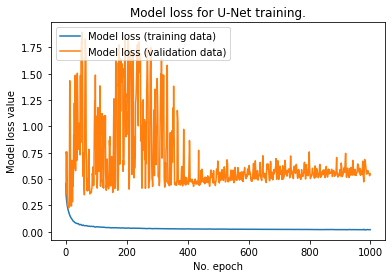

In [ ]:
# Plot history: Model loss
plt.plot(
    history.history['loss'], label='Model loss (training data)'
)

plt.plot(
    history.history['val_loss'], label='Model loss (validation data)'
)

plt.title('Model loss for U-Net training.')
plt.ylabel('Model loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

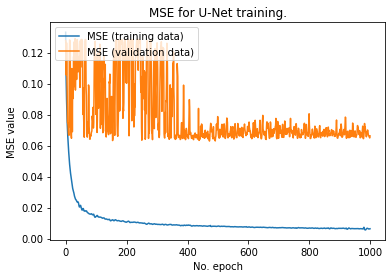

In [ ]:
# Plot history: MSE
plt.plot(
    history.history['mean_squared_error'], label='MSE (training data)'

)

plt.plot(
    history.history['val_mean_squared_error'], label='MSE (validation data)'
)

plt.title('MSE for U-Net training.')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

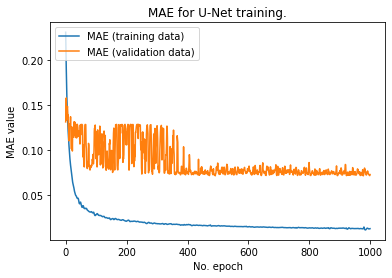

In [ ]:
# Plot history: MAE
plt.plot(
    history.history['mean_absolute_error'], label='MAE (training data)'

)

plt.plot(
    history.history['val_mean_absolute_error'], label='MAE (validation data)'
)

plt.title('MAE for U-Net training.')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()